In [ ]:
%%capture
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud
import re
import spacy
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, roc_auc_score, classification_report

In [ ]:
%matplotlib inline
plt.style.use('bmh')

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

# Data - https://www.kaggle.com/competitions/nlp-getting-started/overview

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
train_data = pd.read_csv("./drive/MyDrive/Tweets/train.csv")
test_data = pd.read_csv("./drive/MyDrive/Tweets/test.csv")

In [ ]:
train_data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### **EDA**

In [ ]:
null_counts = train_data.isnull().sum()

null_counts[null_counts > 0].sort_values(ascending=False)

,0
location,2533
keyword,61


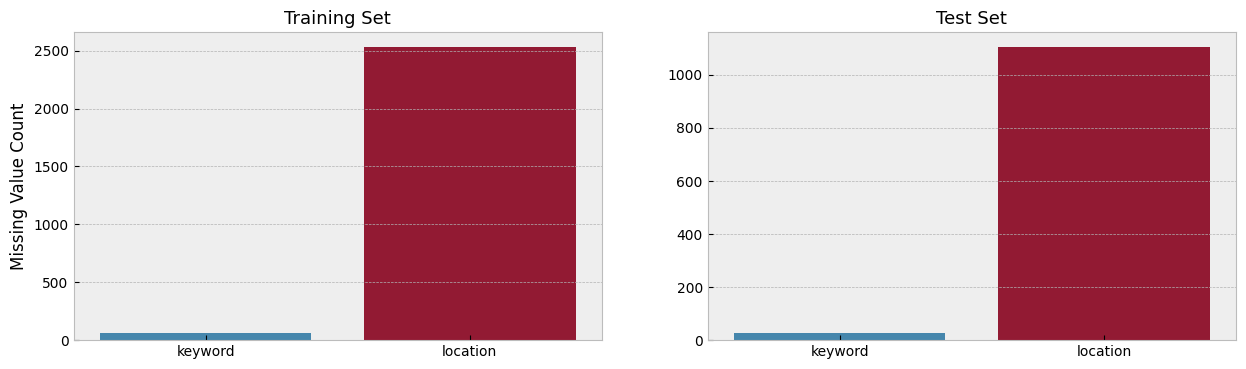

In [ ]:
cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(15, 4), dpi=100)

sns.barplot(x = train_data[cols].isnull().sum().index, y = train_data[cols].isnull().sum().values, hue=cols, legend=False, ax=axes[0])
sns.barplot(x = test_data[cols].isnull().sum().index, y = test_data[cols].isnull().sum().values, hue=cols, legend=False, ax=axes[1])
axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)
axes[0].set_ylabel('Missing Value Count')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.show()

In [ ]:
# Filling these missing data with custom text
for df in [train_data, test_data]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'missing_{col}')

In [ ]:
# unique values
print(f"Unique values in 'keyword' for Train Data is {train_data['keyword'].nunique()} and for Test Data is {test_data['keyword'].nunique()} ")
print(f"Unique values in 'location' for Train Data is {train_data['location'].nunique()} and for Test Data is {test_data['location'].nunique()} ")

Unique values in 'keyword' for Train Data is 222 and for Test Data is 222 
Unique values in 'location' for Train Data is 3342 and for Test Data is 1603 


In [ ]:
train_data.groupby('keyword')['target'].count().sort_values(ascending=False)

,target
keyword,
missing_keyword,61
fatalities,45
deluge,42
armageddon,42
body%20bags,41
...,...
forest%20fire,19
epicentre,12
threat,11


In [ ]:
# Creating new features from the text data such as word count and all
def create_features(df):
  df['text'].astype('str')

  df['word_count'] = df['text'].apply(lambda x : len(x.split()))

  df['unique_word_count'] = df['text'].apply(lambda x : len(set(x.split())))

  df['url_count'] = df['text'].apply(lambda x : len([w for w in x.lower().split() if 'http' in w or 'https' in w]))

  df['char_count'] = df['text'].apply(lambda x : len(x))

  df['punctuation_count'] = df['text'].apply(lambda x : len([c for c in x if c in string.punctuation]))

  df['hashtag_count'] = df['text'].apply(lambda x : len([c for c in x if c == '#']))

  df['mention_count'] = df['text'].apply(lambda x : len([c for c in x if c == '@']))

  return df

In [ ]:
train_data = create_features(train_data)
test_data = create_features(test_data)

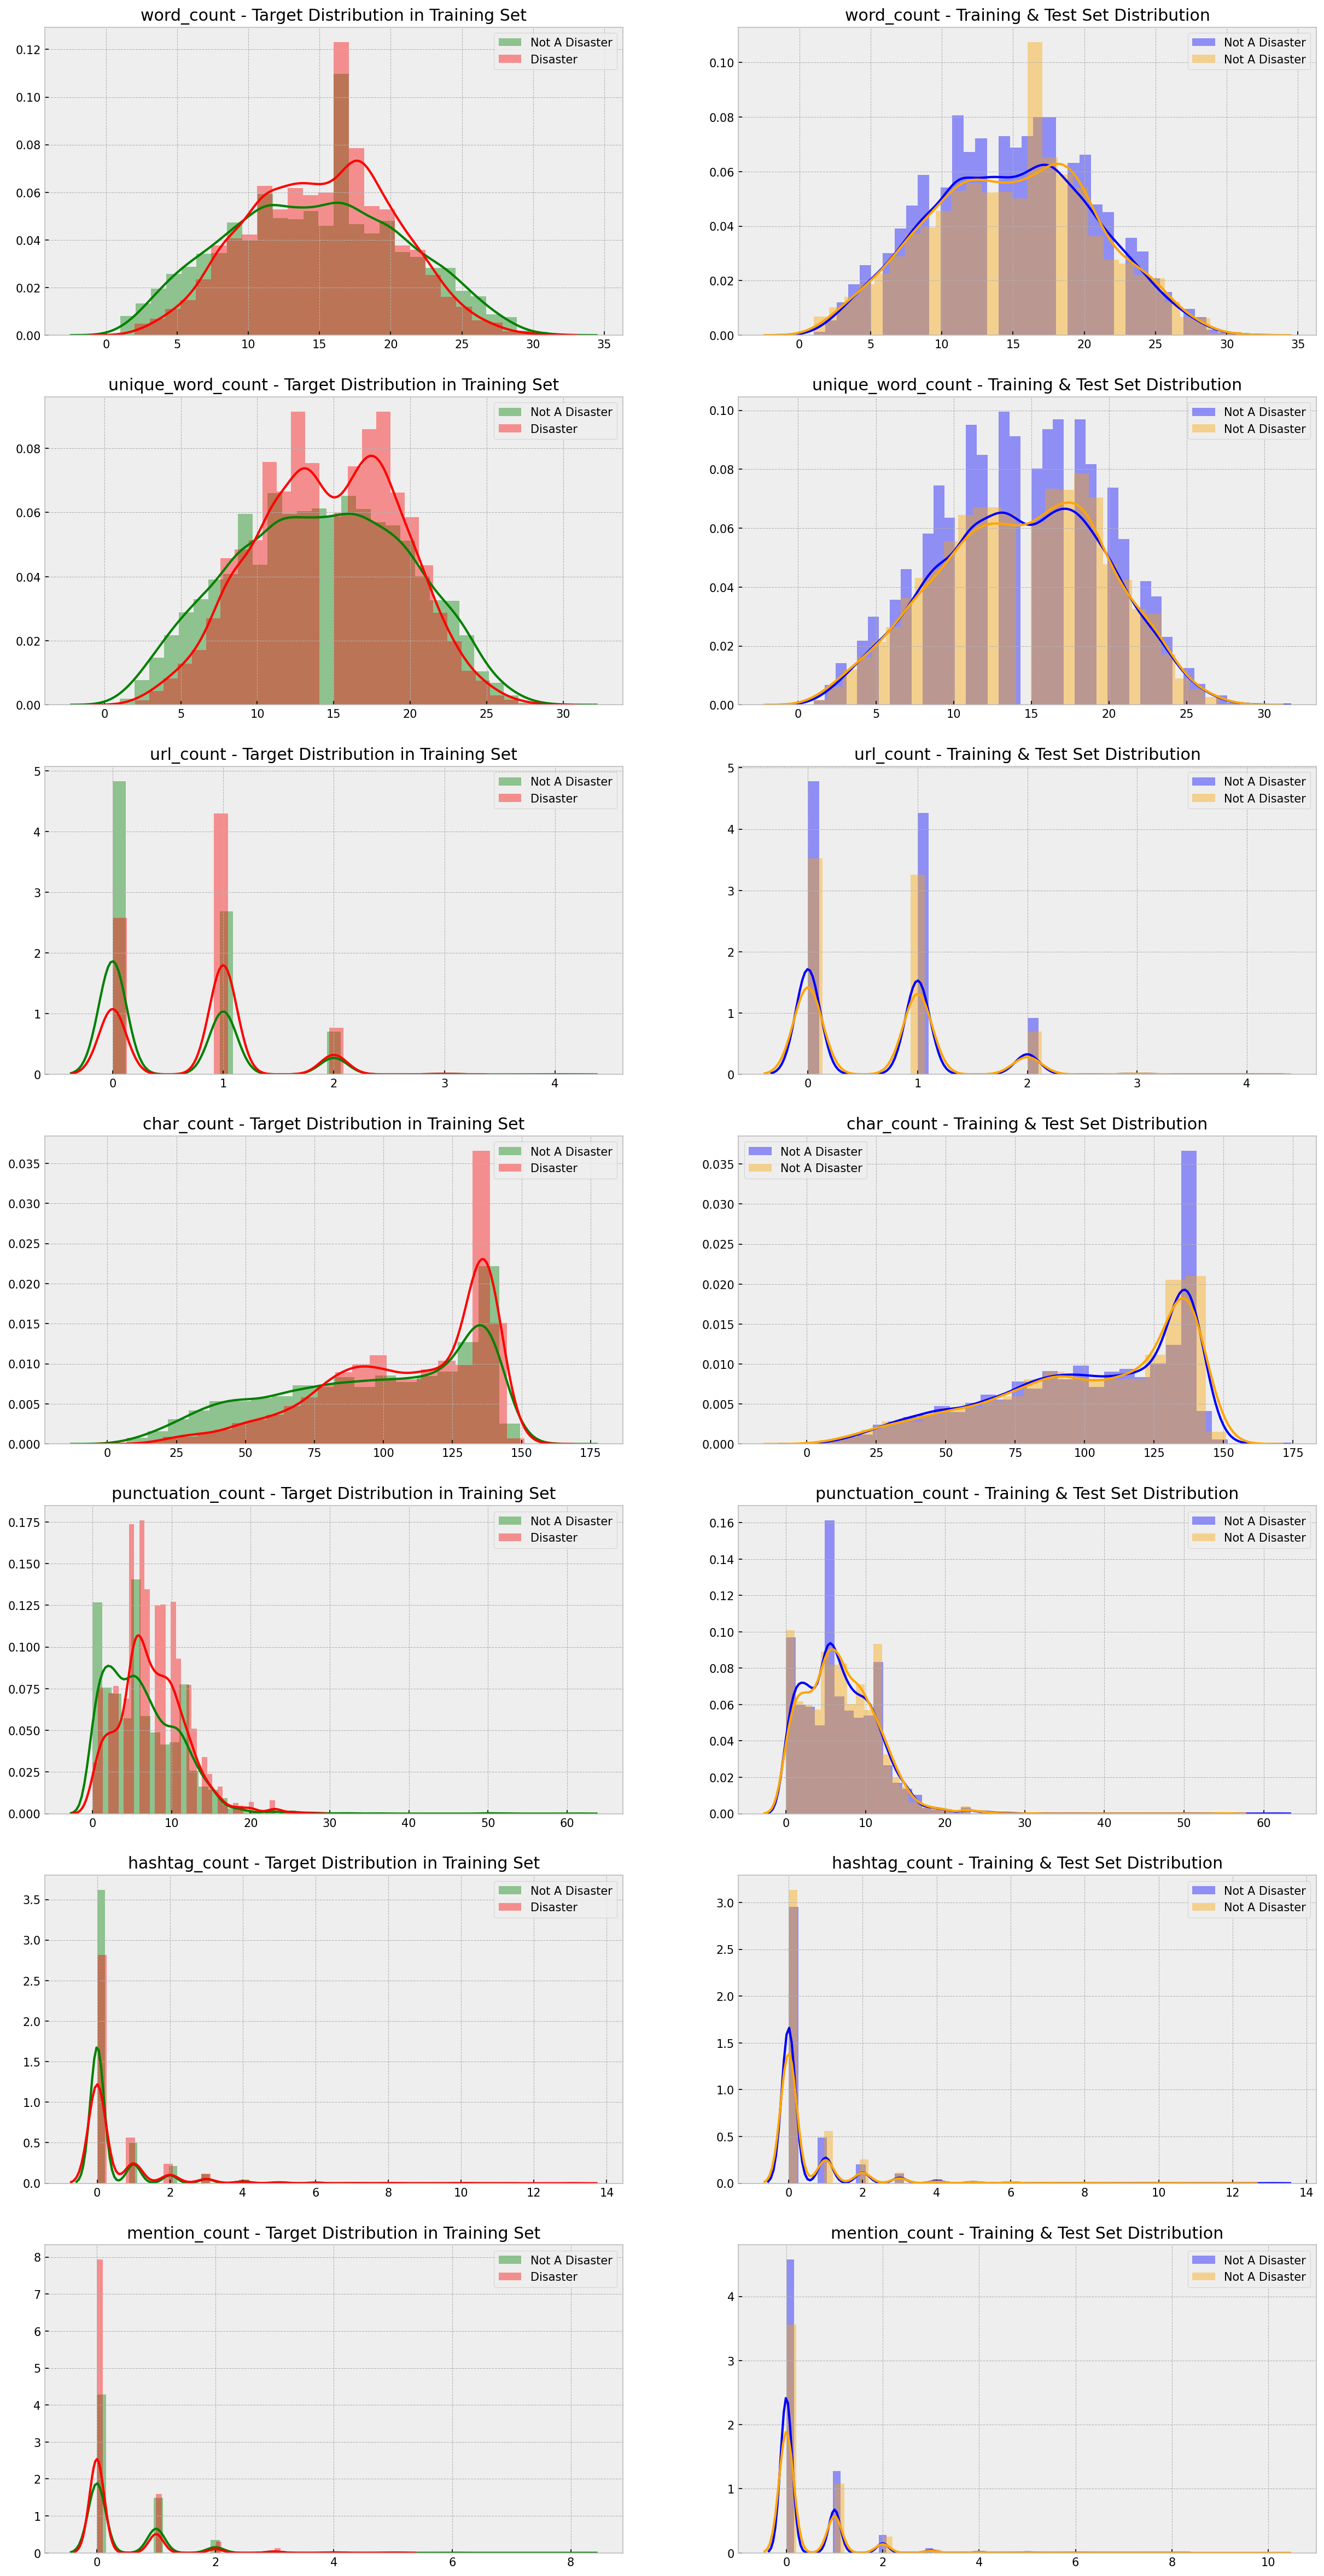

In [ ]:
# Plot the distribution of all the features
DISASTER_TWEETS = train_data['target'] == 1
added_feature = ['word_count', 'unique_word_count', 'url_count', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

fig, axes = plt.subplots(ncols = 2, nrows = len(added_feature), figsize=(20, 40), dpi=150)

for i, feat in enumerate(added_feature):
  sns.distplot(train_data.loc[~DISASTER_TWEETS][feat], ax = axes[i][0], color = 'green', label = "Not A Disaster")
  sns.distplot(train_data.loc[DISASTER_TWEETS][feat], ax = axes[i][0], color = 'red', label = "Disaster")

  sns.distplot(train_data[feat], ax = axes[i][1], color = 'blue', label = "Not A Disaster")
  sns.distplot(test_data[feat], ax = axes[i][1], color = 'orange', label = "Not A Disaster")

  for j in range(2):
    axes[i][j].set_xlabel('')
    axes[i][j].set_ylabel('')
    axes[i][j].tick_params(axis='x')
    axes[i][j].tick_params(axis='y')
    axes[i][j].legend()

  axes[i][0].set_title(f'{feat} - Target Distribution in Training Set')
  axes[i][1].set_title(f'{feat} - Training & Test Set Distribution')

plt.show()

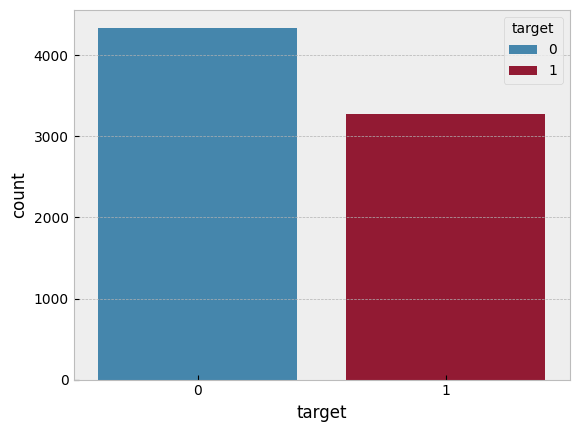

In [ ]:
sns.countplot(x=train_data['target'], hue=train_data['target'])
plt.show()

### **Text Preprocessing**

In [ ]:
nlp = spacy.load("en_core_web_md")

def pre_process(txt):
  docs = nlp(txt.lower())
  processed_tokens = [token.lemma_ for token in docs if not token.is_stop]
  processed_text = " ".join(processed_tokens)

  return processed_text

In [ ]:
train_data['text'] = train_data['text'].apply(pre_process)
test_data['text'] = test_data['text'].apply(pre_process)

In [ ]:
%%time
# we can do more preprocessing

def clean_txt(txt):

  # Special characters
  txt = re.sub(r"I", "I",txt)
  txt = re.sub(r'@\S+', '', txt)
  txt = re.sub(r'#\S+', '', txt)
  txt = re.sub(r'http\S+', '', txt)
  txt = re.sub(r'[^a-zA-Z\s]', '', txt)

  txt = re.sub(r"&gt;", ">", txt)
  txt = re.sub(r"&lt;", "<", txt)
  txt = re.sub(r"&amp;", "&", txt)

  txt = re.sub("<*?>", '', txt)
  emoji_pattern = "["
  emoji_pattern += u"\U0001F600-\U0001F64F" # emoticons
  emoji_pattern += u"\U00002702-\U000027B0" # dingbats
  emoji_pattern += u"\U0001F680-\U0001F6FF" # transport and map symbols
  emoji_pattern += u"\U0001F300-\U0001F5FF" # symbols and pictographs
  emoji_pattern += u"\U0001F1E0-\U0001F1FF" # flags (iOS)
  emoji_pattern += u"\U000024C2-\U0001F251" # enclosed characters
  emoji_pattern += "]+" # One or more of the characters in the set

  txt = re.sub(emoji_pattern, "", txt)

  punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
  for p in punctuations:
      txt = txt.replace(p, f' {p} ')

  txt = txt.replace('...', ' ... ')
  if '...' not in txt:
      txt = txt.replace('..', ' ... ')

  txt = re.sub(r'\s+', ' ', txt).strip()
  contractions = {
      "don't": "do not",
      "can't": "cannot",
      "won't": "will not",
      "it's": "it is",
      "you're": "you are",
      "i'm": "i am",
      # Add more as needed
  }
  for contraction, full_form in contractions.items():
      txt = txt.replace(contraction, full_form)

  return txt

train_data['text'] = train_data['text'].apply(clean_txt)
test_data['text'] = test_data['text'].apply(clean_txt)

CPU times: user 258 ms, sys: 719 µs, total: 259 ms
Wall time: 262 ms


In [ ]:
%%time
def clean_keyword(txt):
  txt = txt.lower()
  txt = re.sub(r'\s+', ' ', txt).strip()
  txt = txt.replace('%20', ' ')

  return txt

train_data['keyword'] = train_data['keyword'].apply(clean_keyword)
test_data['keyword'] = test_data['keyword'].apply(clean_keyword)

CPU times: user 18.2 ms, sys: 0 ns, total: 18.2 ms
Wall time: 18.4 ms


In [ ]:
train_data['text'] = train_data['text'] + ' ' + train_data['keyword']
test_data['text'] = test_data['text'] + ' ' + test_data['keyword']

### **Modelling**

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(train_data['text']).toarray()
y = train_data['target'].astype('int64').values

X_test_tfidf = tfidf_vectorizer.transform(test_data['text']).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [ ]:
class classificationModel:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model

    def model_training(self):
        self.model.fit(self.X_train, self.y_train)
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)
        y_test_prob = self.model.predict_proba(self.X_test)[:, 1]

        return y_train_pred, y_test_pred, y_test_prob


    def model_evaluation(self, train_pred, test_pred, test_prob):
        train_acc = accuracy_score(self.y_train, train_pred)*100
        test_acc = accuracy_score(self.y_test, test_pred)*100
        test_f1 = f1_score(self.y_test, test_pred)
        test_pre = precision_score(self.y_test, test_pred)
        test_recall = recall_score(self.y_test, test_pred)
        test_roc_auc = roc_auc_score(self.y_test, test_prob)

        print(f"Model : {self.model}")
        print(f"Accuracy of Training Data: {train_acc}")
        print(f"Accuracy of Testing Data: {test_acc}")
        print(f"F1 Score of Testing Data: {test_f1}")
        print(f"Pecision of Testing Data: {test_pre}")
        print(f"Recall of Testing Data: {test_recall}")
        print(f"ROC AUC of Testing Data: {test_roc_auc}")
        print("\n***CLASSIFICATION REPORT***\n")
        print(classification_report(self.y_test, test_pred))

#### **Logistic Regression**

In [ ]:
# Logistic Regression
log_model = LogisticRegression()
log_classification = classificationModel(log_model, X_train, X_test, y_train, y_test)

In [ ]:
%%time
# Logistic Regression Traning
train_pred, test_pred, test_prob = log_classification.model_training()

CPU times: user 3.68 s, sys: 746 ms, total: 4.42 s
Wall time: 2.67 s


In [ ]:
%%time
log_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : LogisticRegression()
Accuracy of Training Data: 87.23963220116345
Accuracy of Testing Data: 79.81611208406305
F1 Score of Testing Data: 0.7391058290888511
Pecision of Testing Data: 0.815230961298377
Recall of Testing Data: 0.6759834368530021
ROC AUC of Testing Data: 0.85546125159835

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.82      0.68      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284

CPU times: user 34.2 ms, sys: 34.9 ms, total: 69.2 ms
Wall time: 80.1 ms


#### **XGBoost**

In [ ]:
# XGBoost
xgb_model = XGBClassifier()
xgb_classification = classificationModel(xgb_model, X_train, X_test, y_train, y_test)

In [ ]:
%%time
# XGBoost Traning
train_pred, test_pred, test_prob = xgb_classification.model_training()

CPU times: user 13.2 s, sys: 601 ms, total: 13.8 s
Wall time: 13.9 s


In [ ]:
%%time
xgb_classification.model_evaluation(train_pred, test_pred, test_prob)

Model : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Accuracy of Training Data: 86.15124788890974
Accuracy of Testing Data: 77.1891418563923
F1 Score of Testing Data: 0.6915334517465956
Pecision of Testing Data: 0.8077455048409405
Recall of Testing Data: 0.6045548654244306
ROC AUC of Te

#### **Naive Bayes**

In [ ]:
nb_model = GaussianNB()
nb_classification = classificationModel(nb_model, X_train, X_test, y_train, y_test)

In [ ]:
%%time
# Naive Bayes Training
train_pred_nb, test_pred_nb, test_prob_nb = nb_classification.model_training()

CPU times: user 1.84 s, sys: 177 ms, total: 2.02 s
Wall time: 2.01 s


In [ ]:
%%time
# Naive Bayes Evaluation
nb_classification.model_evaluation(train_pred_nb, test_pred_nb, test_prob_nb)

Model : GaussianNB()
Accuracy of Training Data: 87.31469318821541
Accuracy of Testing Data: 61.42732049036778
F1 Score of Testing Data: 0.6357999173212071
Pecision of Testing Data: 0.5292498279421886
Recall of Testing Data: 0.7960662525879917
ROC AUC of Testing Data: 0.6385490595261658

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.76      0.48      0.59      1318
           1       0.53      0.80      0.64       966

    accuracy                           0.61      2284
   macro avg       0.65      0.64      0.61      2284
weighted avg       0.66      0.61      0.61      2284

CPU times: user 18 ms, sys: 0 ns, total: 18 ms
Wall time: 17.8 ms


#### **Random Forest**

In [ ]:
# Random Forest Model
rf_model = RandomForestClassifier()
rf_classification = classificationModel(rf_model, X_train, X_test, y_train, y_test)

In [ ]:
%%time
# Random Forest Training
train_pred_rf, test_pred_rf, test_prob_rf = rf_classification.model_training()

CPU times: user 1min 32s, sys: 81.7 ms, total: 1min 32s
Wall time: 1min 33s


In [ ]:
%%time
# Random Forest Evaluation
rf_classification.model_evaluation(train_pred_rf, test_pred_rf, test_prob_rf)

Model : RandomForestClassifier()
Accuracy of Training Data: 98.81778945393131
Accuracy of Testing Data: 78.45884413309983
F1 Score of Testing Data: 0.7185354691075515
Pecision of Testing Data: 0.80306905370844
Recall of Testing Data: 0.650103519668737
ROC AUC of Testing Data: 0.8434469222141585

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.77      0.88      0.83      1318
           1       0.80      0.65      0.72       966

    accuracy                           0.78      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.78      0.78      2284

CPU times: user 20.5 ms, sys: 0 ns, total: 20.5 ms
Wall time: 20.3 ms


#### **Gradient Boosting**

In [ ]:
# Gradient Boosting Model
gb_model = GradientBoostingClassifier()
gb_classification = classificationModel(gb_model, X_train, X_test, y_train, y_test)

In [ ]:
%%time
# Gradient Boosting Training
train_pred_gb, test_pred_gb, test_prob_gb = gb_classification.model_training()

CPU times: user 5min 15s, sys: 292 ms, total: 5min 15s
Wall time: 5min 16s


In [ ]:
%%time
# Gradient Boosting Evaluation
gb_classification.model_evaluation(train_pred_gb, test_pred_gb, test_prob_gb)

Model : GradientBoostingClassifier()
Accuracy of Training Data: 77.63182585851004
Accuracy of Testing Data: 73.33625218914186
F1 Score of Testing Data: 0.5865580448065173
Pecision of Testing Data: 0.8520710059171598
Recall of Testing Data: 0.4472049689440994
ROC AUC of Testing Data: 0.7914471389928275

***CLASSIFICATION REPORT***

              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1318
           1       0.85      0.45      0.59       966

    accuracy                           0.73      2284
   macro avg       0.78      0.70      0.69      2284
weighted avg       0.76      0.73      0.71      2284

CPU times: user 23.9 ms, sys: 15 µs, total: 23.9 ms
Wall time: 23.7 ms


In [ ]:
y_pred_final = log_model.predict(X_test_tfidf)

submission_df = pd.DataFrame({'id': test_data['id'], 'target': y_pred_final})
submission_df.to_csv('submission_lrc.csv', index=False)

#### **Hyperpapermeter Tuning**

In [ ]:
log_reg_model = LogisticRegression(solver='liblinear')

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
Best Cross-Validation Score: 0.7853239260453276


In [ ]:
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("F1 Score:", f1_score(y_test, y_val_pred))
print("Classification Report:\n", classification_report(y_test, y_val_pred))

Confusion Matrix:
[[1070  248]
 [ 246  720]]
F1 Score: 0.7445708376421923
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1318
           1       0.74      0.75      0.74       966

    accuracy                           0.78      2284
   macro avg       0.78      0.78      0.78      2284
weighted avg       0.78      0.78      0.78      2284



##### **Best Model**

In [ ]:
y_pred_final = best_model.predict(X_test_tfidf)

submission_df = pd.DataFrame({'id': test_data['id'], 'target': y_pred_final})
submission_df.to_csv('submission.csv', index=False)

### **Implementing Neural Networks**
Starting with the basic LSTM, B-LSTM, GRU using tensorflow!